#### **Import Libraries**

In [1]:
import os 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import numpy as np 
import random 
import math
from itertools import chain
from IPython.display import display, Markdown
import textwrap
import tiktoken
import csv
import time 
import pandas as pd 
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
import transformers
from transformers import DataCollatorWithPadding
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict
import seaborn as sns 
import jax 
import jax.numpy as jnp 
import optax 
from rfp import MLP, Model, ModelParams
from rfp.utils import batch_matrix_with_padding
from rfp.losses import binary_cross_entropy, Supervised_Loss, mse
from rfp.train import Trainer

#### **Parameters**

In [2]:
seed = 1
noise = False 
verbose = False 
sample_size = 1000
test_size = 0.25
version = 3 
lr = 1e-3
epochs = 15_000
nodes = 32

#### **Seed**

In [3]:
np.random.seed(seed)

#### **Set Up Paths**

In [4]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

#### **Set Up Plotting**

In [5]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_36pt/Newsreader_36pt-Light.ttf


#### **First Stage Function**

In [6]:
def fstage(var0, var1, var2, var3, var4):
    return 0.35*(var3 >= 3) + 0.5*var4

In [7]:
# Read in Data Set
df = pd.read_csv(data_csv)

# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(row['Var0'],
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + np.random.normal(size=sample_size)

df = pd.get_dummies(df, columns=['Var0', 'Var1', 'Var3', 'Var4'], drop_first=True)


#### **Plot Treatment Distribution**

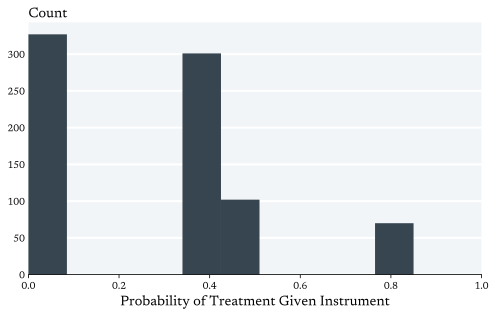

In [8]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

#### **Treatment Fraction**

In [9]:
df.groupby('Instrument')['Treatment'].mean()

Instrument
0    0.000000
1    0.277202
Name: Treatment, dtype: float64

#### **Preprocess Data**

In [10]:
# Select columns that start with 'Var'
var_columns = [col for col in df.columns if col.startswith('Var')]

# Create a numpy matrix from the selected columns
X = df[var_columns].to_numpy().astype(float)

# Feature Matrix
X_normalized = jnp.hstack((jax.nn.standardize(X[:,0]).reshape(-1,1),  X[:,1:]))
print(f"Feature shape: \t\t{X.shape}")
print(f"Feature shape: \t\t{X_normalized.shape}")

D = jnp.array(df['Treatment'].values.reshape(-1,1)).astype(float)
Z = jnp.array(df['Instrument'].values.reshape(-1,1)).astype(float)
inputs = jnp.hstack((X_normalized, Z))

2024-06-19 17:26:55.733200: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


Feature shape: 		(800, 22)
Feature shape: 		(800, 22)


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


#### **Model Setup**

In [11]:
features = inputs.shape[1] ; print(f"Number of Features: {features}")
mlp = MLP([nodes, nodes], jax.nn.relu)
final_activation_fn = jax.nn.sigmoid 
model = Model(mlp, final_activation_fn)
supervised_loss = Supervised_Loss(binary_cross_entropy, model.embellished_fwd_pass)
yuri = Trainer(supervised_loss, optax.sgd(learning_rate=lr, momentum=0.9), epochs)

Number of Features: 23


#### **Train**

In [12]:
# Initialize random key
key = jax.random.PRNGKey(seed)

# Create keys
key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)

# Initialize parameters
params = ModelParams.init_fn(subkey1, mlp, features)

# Split Train and Validation Data
# Shuffle the indices
idx = jax.random.permutation(subkey2, inputs.shape[0])

# Determine the indices for training and validation sets
train_size = int((1 - test_size) * inputs.shape[0])
train_indices = idx[:train_size]
val_indices = idx[train_size:]

# Create boolean masks for training and validation sets
is_in_train = jnp.isin(jnp.arange(inputs.shape[0]), train_indices)
is_in_val = jnp.isin(jnp.arange(inputs.shape[0]), val_indices)

# Train the model
params, opt_params, train_loss_history, val_loss_history = yuri.train_with_val(params, inputs, D, jnp.ones_like(D), is_in_train, is_in_val)

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

In [13]:
inputs.shape

(800, 23)

#### **Plot Losses**

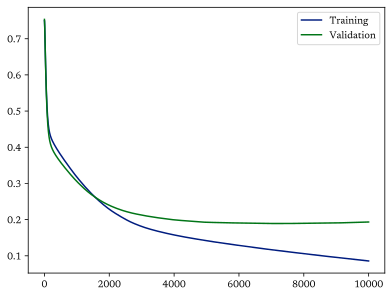

In [14]:
plt.plot(train_loss_history, label='Training')
plt.plot(val_loss_history, label='Validation')
plt.legend()
plt.show()

#### **Estimate**

In [15]:
Dhat = np.array(model.fwd_pass(opt_params, inputs))
Dhat1 = np.array(model.fwd_pass(opt_params, jnp.hstack((X_normalized, jnp.ones_like(Z)))))
Dhat0 = np.array(model.fwd_pass(opt_params, jnp.hstack((X_normalized, jnp.zeros_like(Z)))))
residuals = Dhat - (0.5*Dhat1 + 0.5*Dhat0)
est = jnp.linalg.lstsq(jnp.hstack((residuals.reshape(-1,1), jnp.ones_like(residuals.reshape(-1,1)))), jnp.array(df['Outcome'].values.reshape(-1,1)))[0][0]
df_result = pd.DataFrame({'Estimate': est})
print(est)

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

[3.3473814]


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


#### **Scatter Comps**

(0.0, 1.0)

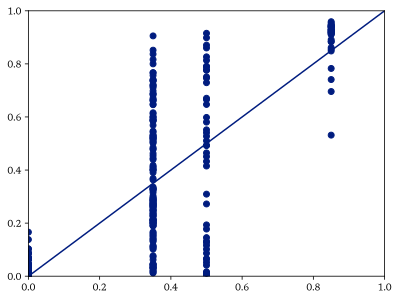

In [16]:
v = (df['FStage_Value']*df['Instrument']).values
plt.scatter(v, Dhat.reshape(-1,))
plt.plot([0,1], [0,1])
plt.xlim(0,1)
plt.ylim(0,1)

#### **Quantile Plot**

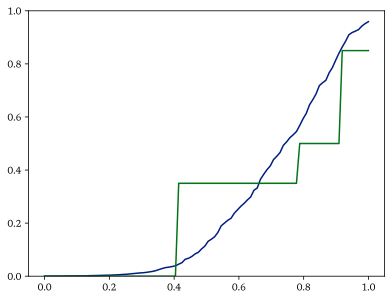

In [17]:
qs = np.linspace(0, 1, 100)
ys1 = np.quantile(Dhat1, qs)
ys2 = np.quantile(df['FStage_Value'].values, qs)
plt.plot(qs, ys1)
plt.plot(qs, ys2)
plt.ylim(0, 1)
plt.show()

#### **Save Results**

In [18]:
# Define the path for the CSV file
file_path = f'./../../../toy-data/exp2/results/nn_{version}_{sample_size}_{noise}.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    # If the file does not exist, write with headers
    df_result[['Estimate']].to_csv(file_path, mode='w', header=True, index=False)
else:
    # If the file exists, append without headers
    df_result[['Estimate']].to_csv(file_path, mode='a', header=False, index=False)